In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import sys 
import os

# TODO: make more pythonic
# this line walks up file directory so rule-vetting is cwd
# Currently this breaks if chunk is run multiple times
os.chdir(os.path.dirname(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))))
print(os.getcwd())

/accounts/grad/wtorous/rule-vetting


In [27]:
import rulevetting.api.viz as viz
from rulevetting.projects.csi_pecarn.dataset import Dataset

In [28]:
eda_df = Dataset().get_data()

 25%|██▌       | 3/12 [00:00<00:00, 21.52it/s]

kwargs {'clean_data': {'use_kappa': False, 'use_robust_av': True}, 'preprocess_data': {'frac_missing_allowed': 0.05}, 'extract_features': {'drop_negative_columns': False}}
read all the csvs...
 ['analysisvariables.csv', 'clinicalpresentationsite.csv', 'clinicalpresentationoutside.csv', 'clinicalpresentationfield.csv', 'demographics.csv', 'injuryclassification.csv', 'injurymechanism.csv', 'kappa.csv', 'medicalhistory.csv', 'radiologyoutside.csv', 'radiologyreview.csv', 'radiologysite.csv']
   site  case_id control_type      id  AlteredMentalStatus  LOC  ambulatory  \
0     1   110001         case  110001                  1.0  1.0         0.0   
1     1   110002         case  110002                  0.0  0.0         0.0   
2     1   110003         case  110003                  0.0  0.0         NaN   
3     1   110004         case  110004                  0.0  0.0         1.0   
4     1   110005         case  110005                  NaN  NaN         NaN   

   FocalNeuroFindings  PainNeck

100%|██████████| 12/12 [00:00<00:00, 43.63it/s]
0it [00:00, ?it/s]

There
   FieldDocumentation  EMSArrivalDate EMSArrivalDateND  EMSArrivalTime  \
0                   1          110001             case          110001   
1                   1          110002             case          110002   
2                   1          110003             case          110003   
3                   1          110004             case          110004   
4                   1          110005             case          110005   

  EMSArrivalTimeND EMSEstimateTime  PtAmbulatoryPriorEMSArrival  \
0              EMS        1/1/2000                            0   
1               NR             NaN                            0   
2              OTR             NaN                            0   
3              OTR             NaN                            0   
4              OTR             NaN                            0   

  PatientsPosition  HxLOC  SectionGCSAvailable  ...  \
0              NaN      1                  6.0  ...   
1              NaN      0           

7it [00:00, 14.42it/s]


----
AVPUMentalTxtCat
Accepted
----
AVPUMentaltxt
----
AVPUMentaltxtCat
Accepted
----
ArrivalTimeND
----
Cardiovascular
Accepted
----
CervicalSpineImmobilization
Accepted
----
CervicalSpineIntervOther
Accepted
----
CervicalSpineIntervOthertxt
----
CervicalSpineIntervRLB
----
CervicalSpinePrecautions
Accepted
----
CervicalSpinePrecautionsCC
Accepted
----
CervicalSpinePrecautionsOther
----
CervicalSpinePrecautionsOthertxt
----
CervicalSpinePrecautionsRLB
----
DermatologicalSkin
Accepted
----
DxCspineInjury
----
EDArrivalDateND
----
EDArrivalTimeND
----
EMSArrivalDateND
----
EMSArrivalTimeND
----
EMSEstimateTime
----
EstimateTimeInjury
----
Ethnicity
----
GCSEye
Accepted
----
Gastrointestinal
Accepted
----
Gender
----
HEENT
Accepted
----
HeadFirst
Accepted
----
HeadFirstRegion
----
ICD9Location1
----
ICD9Location2
----
ICD9Location3
----
ICD9MechInjury1
----
ICD9MechInjury2
----
ICD9MechInjury3
----
InjuryPrimaryMechanism
----
InjuryPrimaryMechanismtxt
----
InjuryTime
----
LocEvalPhysicia

/usr/local/linux/anaconda3.8/lib/python3.8/site-packages/pandas/core/indexing.py:1787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)
/usr/local/linux/anaconda3.8/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/usr/local/linux/anaconda3.8/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

In [29]:
outcome_def = 'csi_injury'

In [30]:
print(eda_df.shape)

(2901, 181)


In [31]:
# get list of columns with only two recorded outcomes
binary_columns = eda_df.columns[eda_df.nunique()==2]
binary_eda_data = eda_df.loc[:,binary_columns].copy() 

cont_columns = eda_df.columns[eda_df.nunique()!=2]
cont_eda_data = eda_df.loc[:,cont_columns].copy()
cont_eda_data.loc[:,outcome_def] = eda_df.loc[:,outcome_def].copy() #add binary outcome indicator back in

In [32]:
# outcome indicator is double counted
print(eda_df.shape)
print(binary_eda_data.shape)
print(cont_eda_data.shape)

(2901, 181)
(2901, 165)
(2901, 17)


# Summary EDA

In [33]:
eda_df.describe()

,AVPUMental,AlteredMentalStatus2,ArrPtIntub,ArrivalDate,ArrivalTime,Assault,AxialLoadAnyDoc,BodyAsAWhole0,BodyAsAWhole2,BodyAsAWhole5,...,Respiratory_binary,TotalGCSAvailable_binary,TotalGCSManual_binary,clotheslining_binary,helmet_binary,csi_injury,AgeInYears_<2,AgeInYears_2-5,AgeInYears_5-13,AgeInYears_13+
count,2901.000000,2901.000000,2901.000000,2901.000000,2.901000e+03,2901.000000,2901.000000,2901.000000,2901.000000,2901.000000,...,2901.000000,2901.000000,2901.000000,2901.000000,2901.000000,2901.000000,2901.000000,2901.000000,2901.000000,2901.000000
mean,3.918649,0.247846,0.032747,9.851431,9.967265e+05,0.032058,0.250259,0.003102,0.000345,0.000345,...,0.158221,0.082730,0.066529,0.009997,0.079283,0.168907,0.064805,0.132368,0.422613,0.380214
std,2.739167,0.431836,0.178005,4.743670,4.752908e+05,0.176184,0.433237,0.055622,0.018566,0.018566,...,0.365011,0.275521,0.249247,0.099499,0.270227,0.374735,0.246224,0.338949,0.494060,0.485523
min,0.000000,0.000000,0.000000,1.000000,1.100010e+05,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,7.000000,7.108560e+05,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,0.000000,0.000000,10.000000,1.011618e+06,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6.000000,0.000000,0.000000,15.000000,1.512486e+06,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,6.000000,1.000000,1.000000,17.000000,1.713132e+06,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [34]:
binary_corrs = binary_eda_data.corr(method='spearman')
cont_corrs = cont_eda_data.corr(method='spearman')

print(cont_corrs)

                       AVPUMental  ArrivalDate  ArrivalTime  \
AVPUMental               1.000000     0.071103     0.071966   
ArrivalDate              0.071103     1.000000     0.997227   
ArrivalTime              0.071966     0.997227     1.000000   
CervicalSpineIntervCC   -0.137758     0.033824     0.032851   
EDArrivalDate            0.071966     0.997227     1.000000   
EDArrivalTime            0.074173     0.997225     0.994656   
EDDocumentation          0.071103     1.000000     0.997227   
EMSArrivalDate           0.071966     0.997227     1.000000   
EMSArrivalTime           0.074173     0.997225     0.994656   
FallDownStairs           0.001291     0.040368     0.040534   
FallFromElevation       -0.010494     0.015331     0.014854   
FieldDocumentation       0.071103     1.000000     0.997227   
MVCSpeed                 0.041904    -0.067561    -0.068599   
ModeArrival              0.074173     0.997225     0.994656   
OMTSpeed                 0.033100     0.006542     0.00

In [35]:
ems_time = cont_eda_data.loc[:,'EMSEstimateTime']
ems_time.describe()

KeyError: 'EMSEstimateTime'

/accounts/grad/wtorous/.local/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


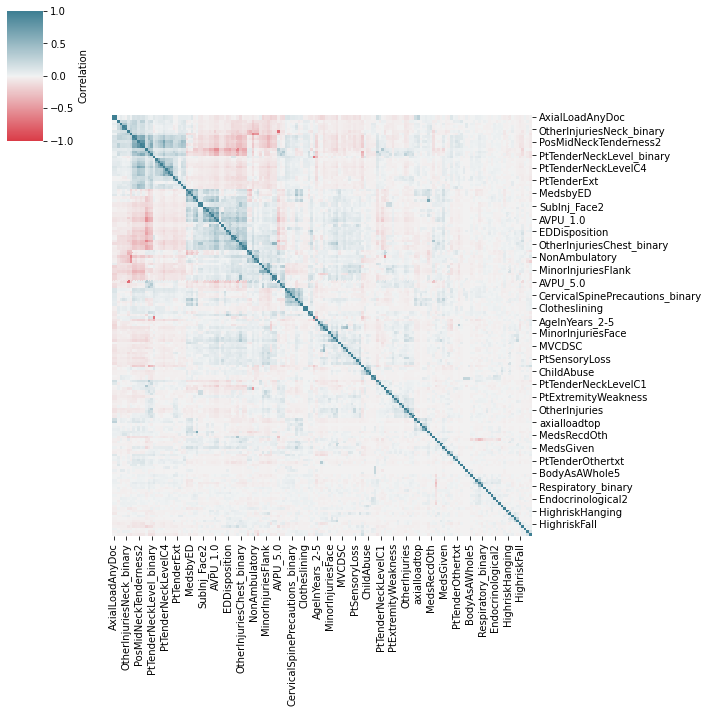

In [36]:
binary_corrmap = sns.clustermap(binary_corrs, cmap=viz.cmap_div, vmin=-1, vmax=1, cbar_kws={'label': 'Correlation'})
binary_corrmap.ax_row_dendrogram.set_visible(False)
binary_corrmap.ax_col_dendrogram.set_visible(False)

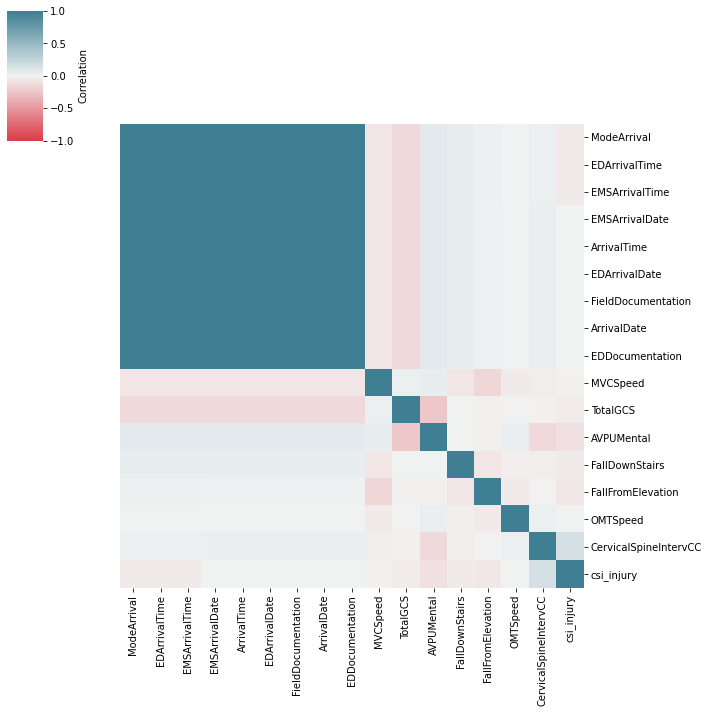

In [37]:
cont_corrmap = sns.clustermap(cont_corrs, cmap=viz.cmap_div, vmin=-1, vmax=1, cbar_kws={'label': 'Correlation'})
cont_corrmap.ax_row_dendrogram.set_visible(False)
cont_corrmap.ax_col_dendrogram.set_visible(False)

In [38]:
print(binary_corrs)

                      AlteredMentalStatus2  ArrPtIntub   Assault  \
AlteredMentalStatus2              1.000000    0.320539  0.013372   
ArrPtIntub                        0.320539    1.000000 -0.011495   
Assault                           0.013372   -0.011495  1.000000   
AxialLoadAnyDoc                  -0.049647   -0.048177 -0.032861   
BodyAsAWhole0                    -0.032023   -0.010265 -0.010152   
...                                    ...         ...       ...   
csi_injury                        0.097074    0.077303 -0.061152   
AgeInYears_<2                     0.079146   -0.009099  0.047479   
AgeInYears_2-5                    0.079692    0.025290 -0.053760   
AgeInYears_5-13                  -0.053107    0.007261 -0.100237   
AgeInYears_13+                   -0.041731   -0.020429  0.115452   

                      AxialLoadAnyDoc  BodyAsAWhole0  BodyAsAWhole2  \
AlteredMentalStatus2        -0.049647      -0.032023      -0.010660   
ArrPtIntub                  -0.048177    

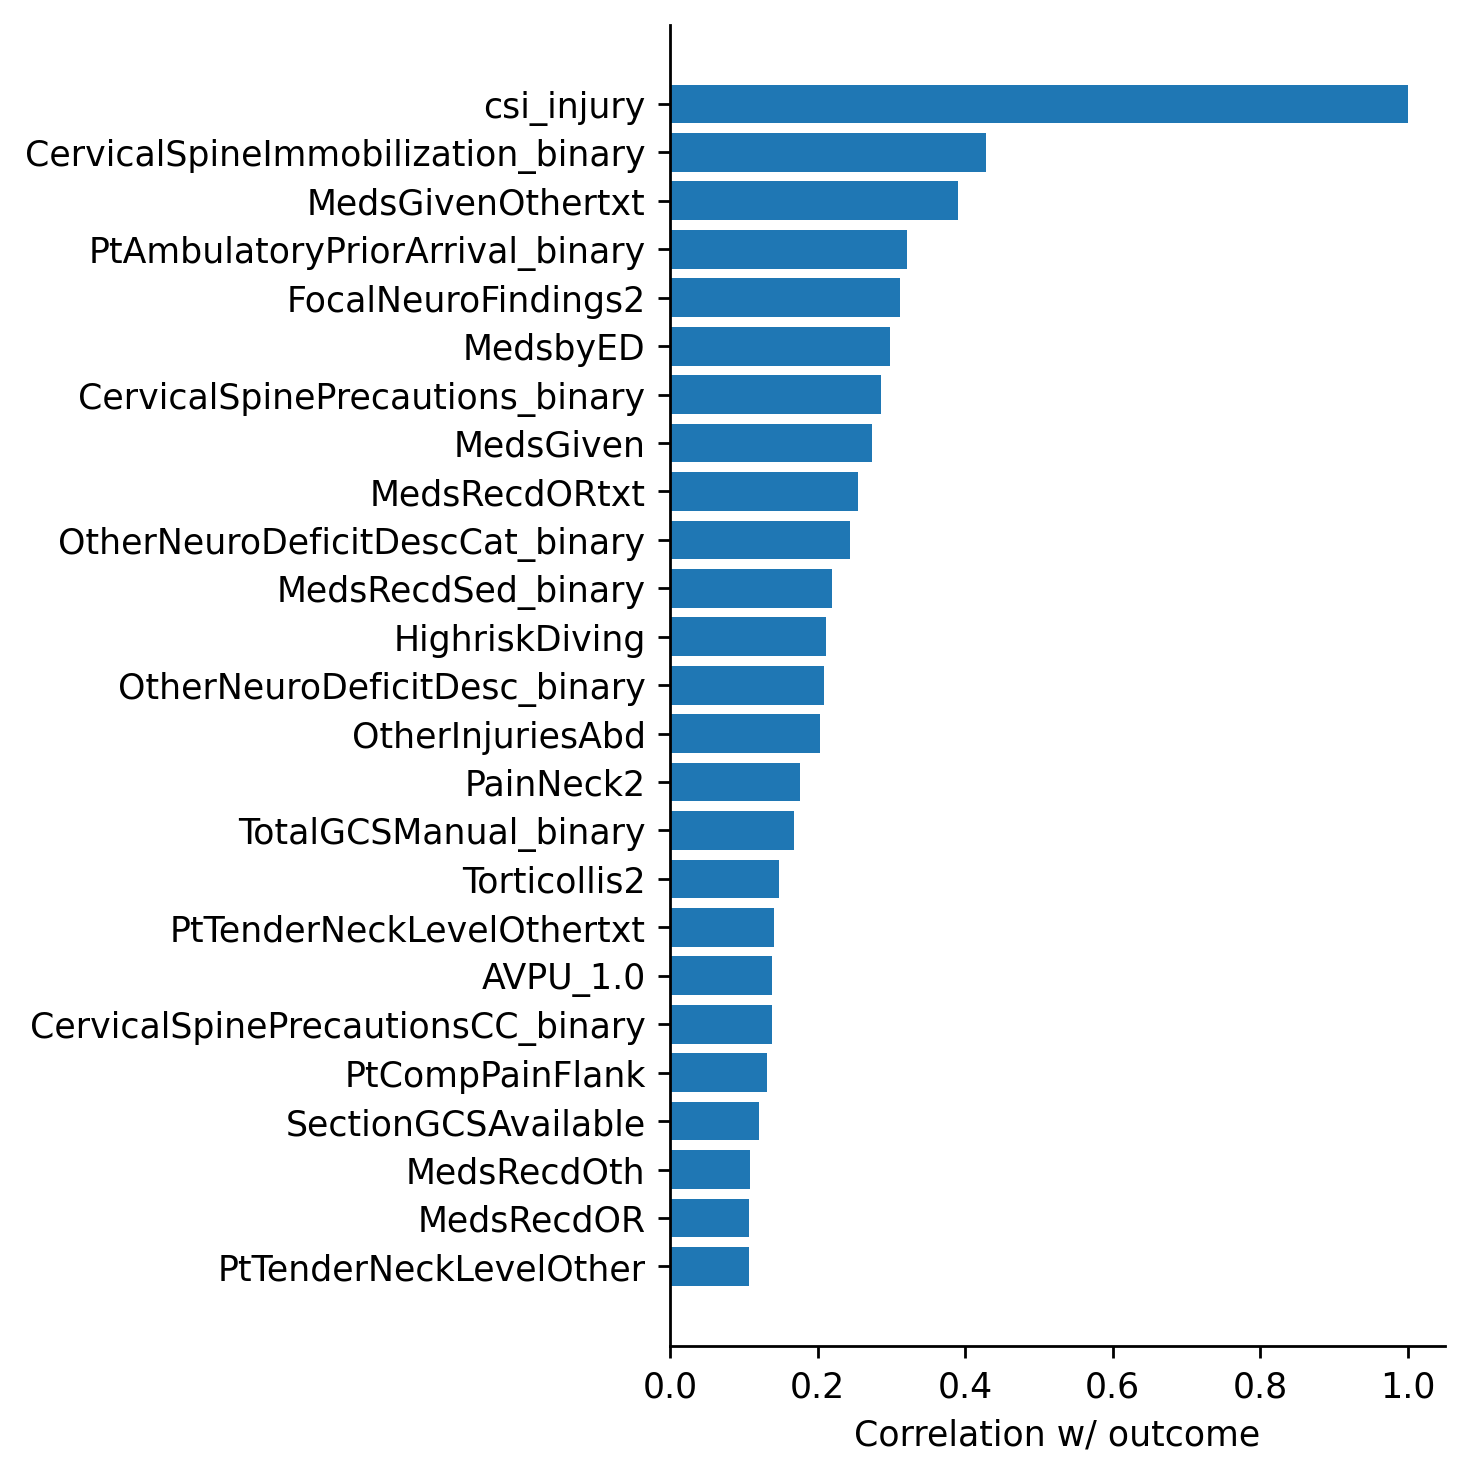

In [39]:
plt.figure(dpi=250, figsize=(4, 7))
vals = binary_corrs[outcome_def]
args = np.argsort(vals)
labs = vals.index.values[args]
ax = plt.subplot(111)
plt.barh(labs[-25:], vals[args][-25:])
plt.xlabel('Correlation w/ outcome')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

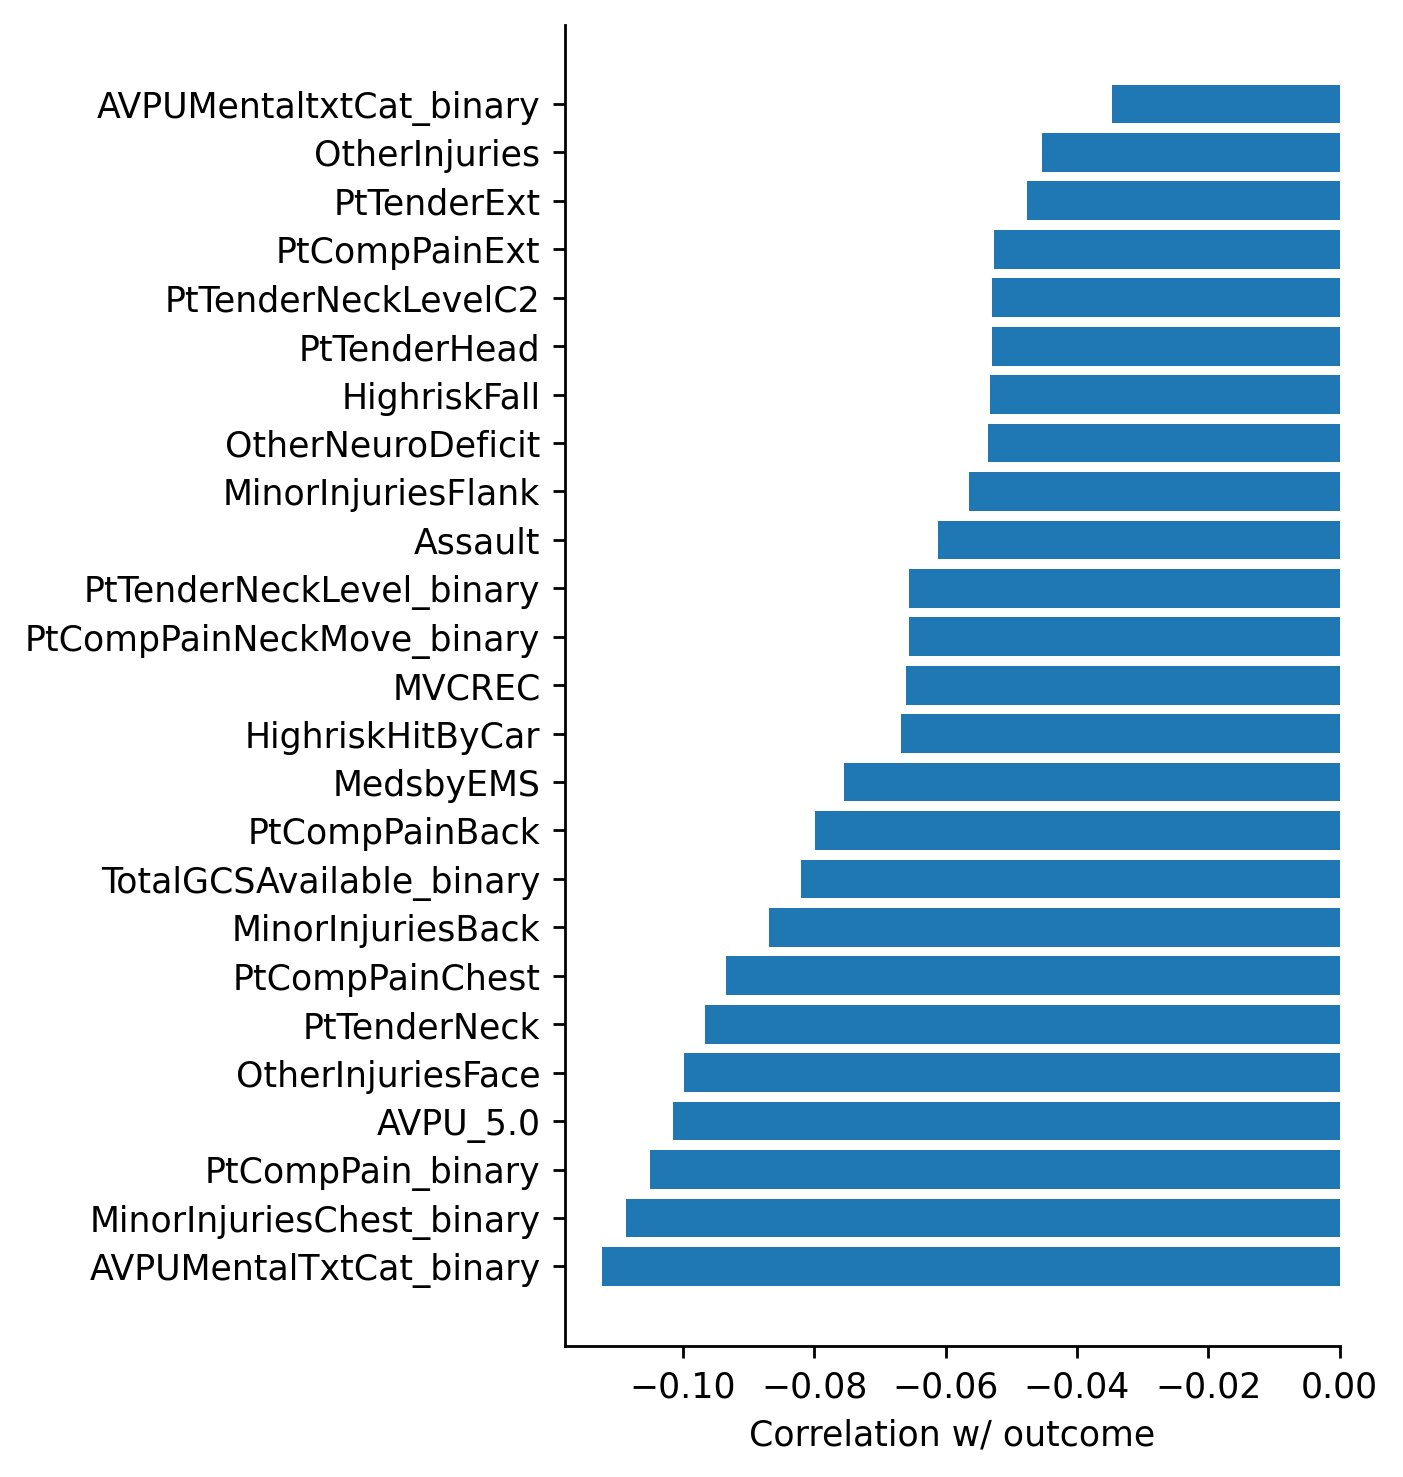

In [40]:
plt.figure(dpi=250, figsize=(4, 7))
vals = binary_corrs[outcome_def]
args = np.argsort(vals)
labs = vals.index.values[args]
ax = plt.subplot(111)
plt.barh(labs[:25], vals[args][:25])
plt.xlabel('Correlation w/ outcome')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

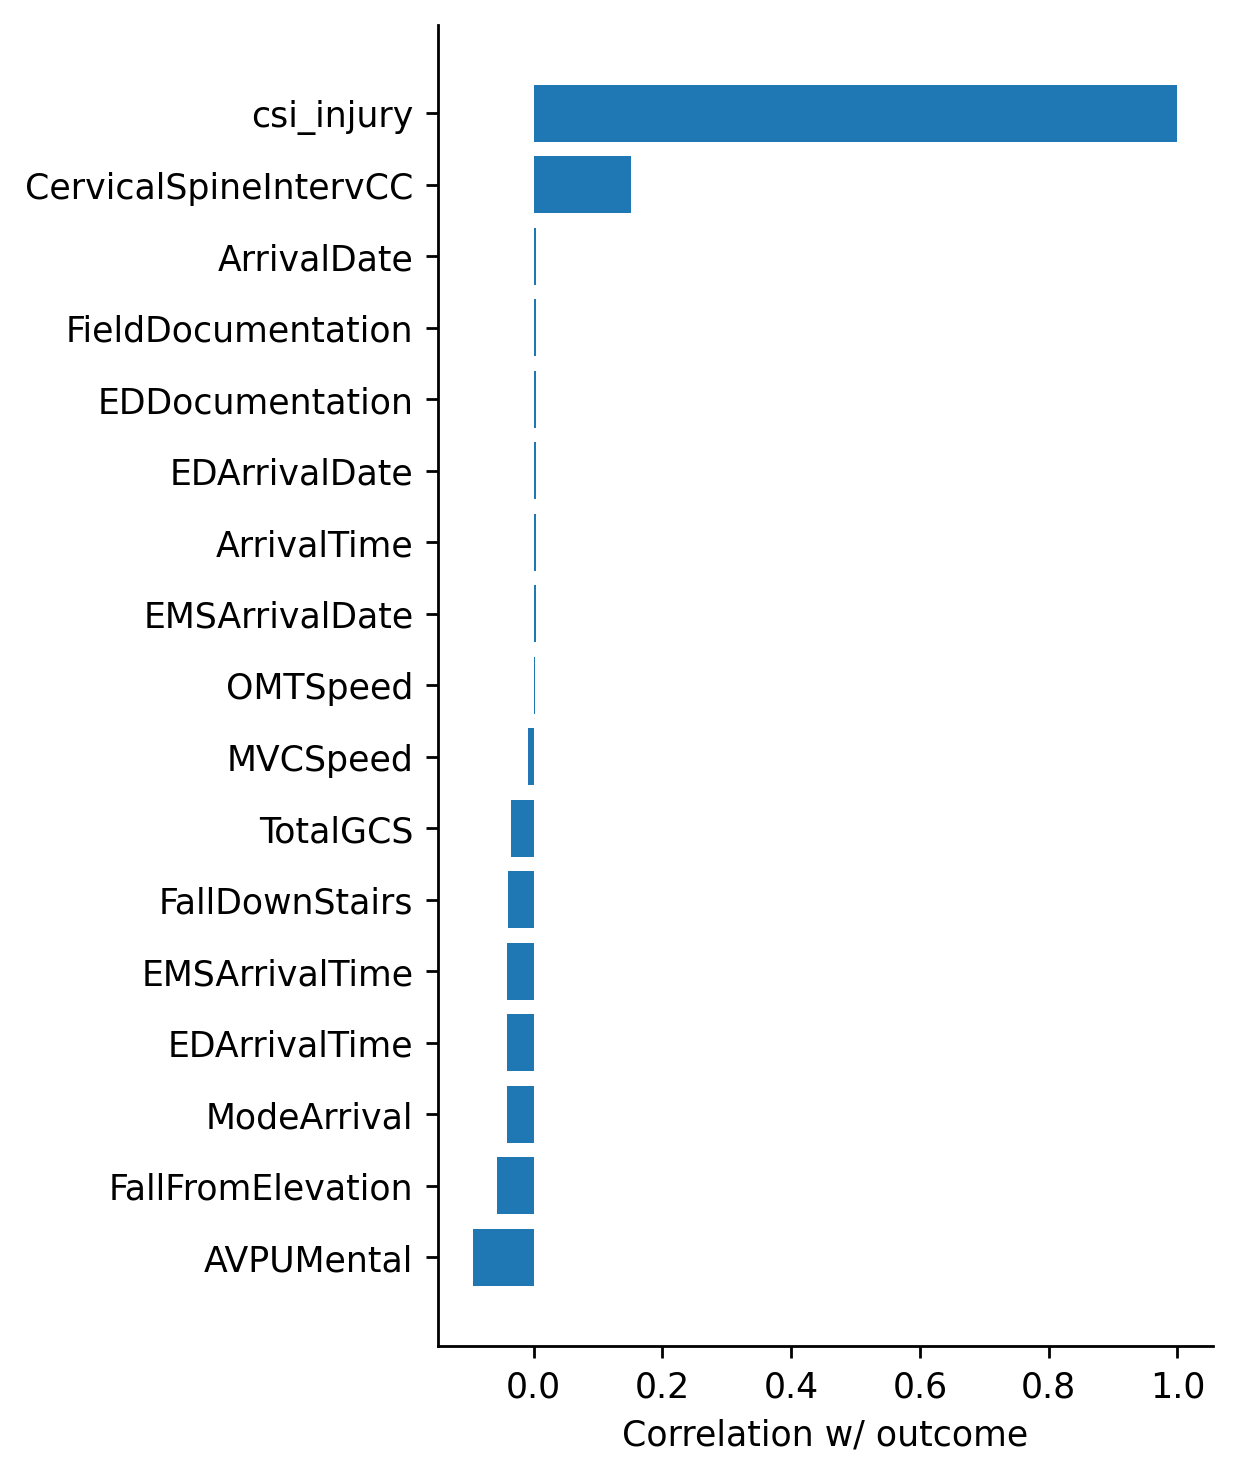

In [41]:
plt.figure(dpi=250, figsize=(4, 7))
vals = cont_corrs[outcome_def]
args = np.argsort(vals)
labs = vals.index.values[args]
ax = plt.subplot(111)
plt.barh(labs, vals[args])
plt.xlabel('Correlation w/ outcome')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

# EDA of Missingness

In [ ]:
# get percent missing by column
print("25 Covariates with Highest Percent Missingness\n")
print("All Covariates:")
missing_frac = (eda_df.isna().sum() / eda_df.shape[0]) * 100
print(missing_frac.sort_values(ascending=False)[:25])

print("\nContinuous Covariates:")
bin_missing_frac = (binary_eda_data.isna().sum() / binary_eda_data.shape[0]) * 100
print(bin_missing_frac.sort_values(ascending=False)[:25])

In [ ]:
complete_binary_covar = binary_columns[bin_missing_frac==0]
print("Binary covar. with no missing data:",len(complete_binary_covar))

missing_columns = binary_columns[bin_missing_frac!=0]
print("Binary covar. with some missing data:",len(missing_columns))

In [ ]:
binary_missing_bools = binary_eda_data[missing_columns].isna()
binary_missing_corrs = binary_missing_bools.corr(method='spearman')

In [ ]:
corrmap = sns.clustermap(binary_missing_corrs, cmap=viz.cmap_div, vmin=-1, vmax=1, cbar_kws={'label': 'Correlation'})
corrmap.ax_row_dendrogram.set_visible(False)
corrmap.ax_col_dendrogram.set_visible(False)

# EDA of Demographic Data

In [ ]:
eda_demographic_df = pd.read_csv("data/csi_pecarn/raw/demographics.csv").set_index(["studysubjectid"])
print(eda_demographic_df.columns)

In [ ]:
gender_df = eda_demographic_df.groupby('site')['Gender'].value_counts(normalize=True)

fig = plt.figure()
plt.title('Summary of Gender Variable Across Study Sites')
gender_df.unstack().plot(kind='bar', stacked=True,ax=fig.gca())
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xticks(rotation = 0)
plt.show()

In [ ]:
race_df = eda_demographic_df.groupby('site')['Race'].value_counts(normalize=True)

fig = plt.figure()
plt.title('Summary of Race Variable Across Study Sites')
race_df.unstack().plot(kind='bar', stacked=True,ax=fig.gca())
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xticks(rotation = 0)
plt.show()

In [ ]:
ethnicity_df = eda_demographic_df.groupby('site')['Ethnicity'].value_counts(normalize=True)

fig = plt.figure()
plt.title('Summary of Ethnicity Variable Across Study Sites')
ethnicity_df.unstack().plot(kind='bar', stacked=True,ax=fig.gca())
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xticks(rotation = 0)
plt.show()

In [ ]:
payor_df = eda_demographic_df.groupby('site')['PayorType'].value_counts(normalize=True)

fig = plt.figure()
plt.title('Summary of Payor Type Across Study Sites')
payor_df.unstack().plot(kind='bar', stacked=True,ax=fig.gca())
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xticks(rotation = 0)
plt.show()

In [ ]:
age_df = eda_demographic_df[['site','AgeInYears']]


bins = [0, 2, 5, 10, 13, np.inf]
names = ['<2', '2-5', '5-10', '10-13', '13+']

age_df.loc[:,['AgeBin']] = pd.cut(age_df.loc[:,'AgeInYears'], bins, labels=names)

age_range_df = age_df.groupby('site')['AgeBin'].value_counts(normalize=True)

fig = plt.figure()
plt.title('Summary of Age Range Across Study Sites')
age_range_df.unstack().plot(kind='bar', stacked=True,ax=fig.gca())
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xticks(rotation = 0)
plt.show()
